In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


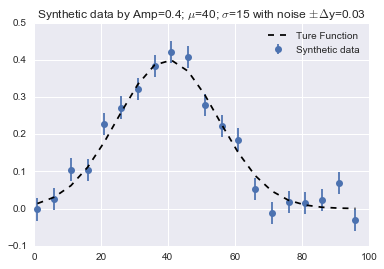

In [2]:
x = np.arange(1,100,5)
# Parameters for gaussian
amp_true = 0.4
miu_true = 40
sigma_true =15
# Gaussian function
gauss = lambda x,amp,miu,sigma: amp*np.exp(-(x-miu)**2/(2.*sigma**2))
f_true = gauss(x=x,amp=amp_true, miu=miu_true, sigma=sigma_true)

# add noise to the data points
noise = np.random.normal(loc=0.0, scale=0.03, size=len(x)) 
#For real histogram data noise is not Gassian! here is only a simply hypothesis. 

#numpy.random.normal(loc=miu, scale=sigma, size=None)
f = f_true+noise
deltay_true=0.03
f_error = np.ones_like(f_true)*deltay_true
#error bar is the sigma for y value, I keep it the same as the sigma of noise on purpose;!!!

fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)

axs.errorbar(x, f, yerr=f_error,label='Synthetic data',fmt='o')
axs.plot(x,gauss(x,amp_true,miu_true,sigma_true),label='Ture Function',linestyle='--', color='black')
axs.legend(loc='upper right')
axs.set_title('Synthetic data by Amp={0}; $\mu$={1}; $\sigma$={2} with noise $\pm \Delta$y={3}'.
              format(amp_true, miu_true,sigma_true,deltay_true))
plt.show()


fit_value with oppropriate y error bar: [  0.41087623  39.36816694  14.93086989]
fit_sigma with oppropriate y error bar: [ 0.01598378  0.67042353  0.67230206]
fit_value with overestimate y error bar: [  0.41087623  39.36816694  14.93086989]
fit_sigma with overestimate y error bar: [ 0.03196756  1.34084706  1.34460413]
fit_value with underestimate y error bar: [  0.41087623  39.36816694  14.93086989]
fit_sigma with underestimate y error bar: [ 0.00799189  0.33521177  0.33615103]


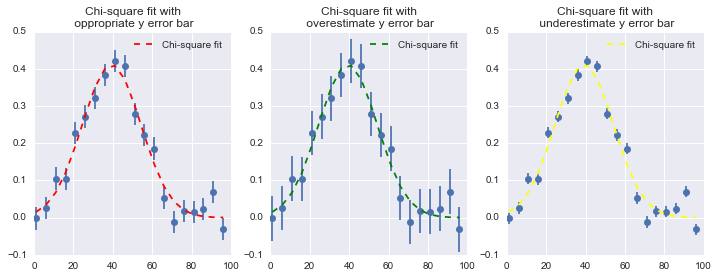

In [3]:
#chi-sq fit
def graph(formula, x_range, color='black', alpha=1):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y, color=color, alpha=alpha)
    
import scipy.optimize as opt 
vars0 = np.array([0.35, 44, 15])

#this section show over/underestimate the sigma has substantial impact on the fit parameter variance in chi-square fit.
# a hiden hypothesis is the probablity of the observed y should be Gassuian distribution, 
# errorbar of y indicates the sigma of such Gaussian distribution.
# if absolute_sigma=False; opt.curve_fit can optimize the error propagation from y to variables,
# but that is beyond the original chi-square defination.
f_error1 = np.ones_like(f_true)*0.03
f_error2 = np.ones_like(f_true)*0.03*2 
f_error3 = np.ones_like(f_true)*0.03/2 
result_chi1=opt.curve_fit(gauss, x, f, vars0, f_error1, absolute_sigma=True)
print('fit_value with oppropriate y error bar:', result_chi1[0])
print('fit_sigma with oppropriate y error bar:', np.sqrt(np.diag(result_chi1[1])))
result_chi2=opt.curve_fit(gauss, x, f, vars0, f_error2, absolute_sigma=True)
print('fit_value with overestimate y error bar:', result_chi2[0])
print('fit_sigma with overestimate y error bar:', np.sqrt(np.diag(result_chi2[1])))
result_chi3=opt.curve_fit(gauss, x, f, vars0, f_error3, absolute_sigma=True)
print('fit_value with underestimate y error bar:', result_chi3[0])
print('fit_sigma with underestimate y error bar:', np.sqrt(np.diag(result_chi3[1])))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax = axs[0]
ax.errorbar(x, f, yerr=f_error1,fmt='o')
ax.plot(x,gauss(x,result_chi1[0][0],result_chi1[0][1],result_chi1[0][2]),
        label='Chi-square fit', linestyle='--',color='red')
ax.set_title('Chi-square fit with\n oppropriate y error bar')
ax.legend(loc='upper right')
ax = axs[1]
ax.errorbar(x, f, yerr=f_error2,fmt='o')
ax.plot(x,gauss(x,result_chi2[0][0],result_chi2[0][1],result_chi2[0][2]),
        label='Chi-square fit', linestyle='--',color='green')
ax.set_title('Chi-square fit with\n overestimate y error bar')
ax.legend(loc='upper right')
ax = axs[2]
ax.errorbar(x, f, yerr=f_error3,fmt='o')
ax.plot(x,gauss(x,result_chi3[0][0],result_chi3[0][1],result_chi3[0][2]),
        label='Chi-square fit', linestyle='--',color='yellow')
ax.set_title('Chi-square fit with\n underestimate y error bar')
ax.legend(loc='upper right')
plt.show()

100%|██████████████████████████████████████| 2000/2000 [04:19<00:00,  7.70it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F66EA53B38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F66E6D5748>]], dtype=object)

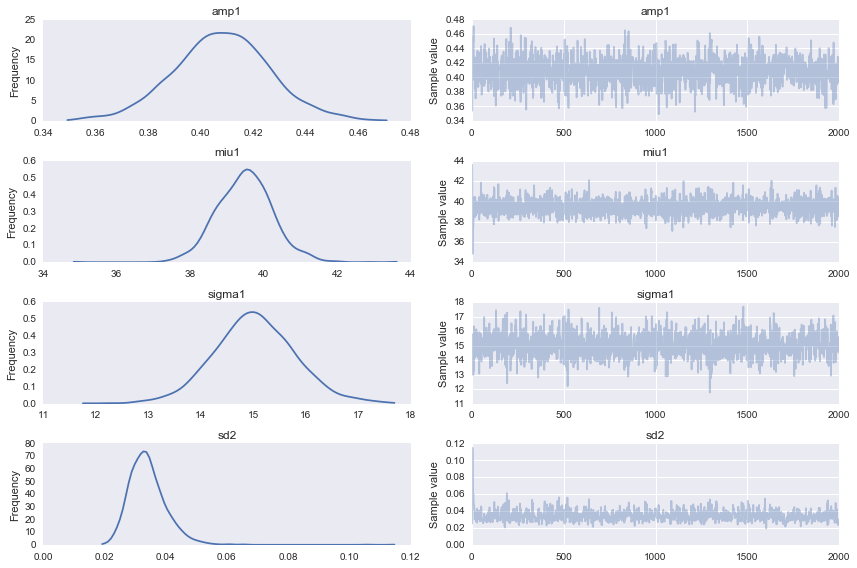

In [4]:
#for mcmc errorbar of each y value doesn't exit in the hyprothesis anymore;
#In fact, MCMC even don't require the probabality of its observed y to be Gassuian distribution,
# it only use prior distribution as a very relax prerequisite for the observed y and unknown variable need to predict.
# such flexible prerequisite allow MCMC to be more practical for some undefine or underdeveloped condition than than 
# Chi-square fit, which is too rigid.  
# But to construct a Bayesian model, 
# the unknown variables in the model and the stochastic observation all must be assigned a prior distribution.

with pm.Model() as model:
    amp1 = pm.Normal('amp1', mu=0.35, sd=0.1)
    miu1 = pm.Normal('miu1', mu=44, sd=5)
    sigma1= pm.Normal('sigma1', mu=15, sd=5)    
    sd1 = pm.HalfNormal('sd2', sd=0.03)
    y_est1 = amp1*np.exp(-(x-miu1)**2/(2.*sigma1**2)) 
    likelihood1 = pm.Normal('f', mu=y_est1, sd=sd1, observed=f)
    #tdist change likelihood can fix weird points far away from reasonable region
    start1 = pm.find_MAP() #find  starting value by optimization 
    step1 = pm.NUTS(state=start1) #instantiate MCMC sampling algorithm
    trace1 = pm.sample(2000, step1, njobs=1, progressbar=True)
    
pm.traceplot(trace1)

In [7]:
#output the general fit result
pm.summary(trace1);


amp1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.408            0.018            0.001            [0.373, 0.446]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.372          0.397          0.408          0.420          0.445


miu1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  39.493           0.767            0.016            [38.100, 41.110]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  38.044         38.984         39.500         39.979         41.086


sigma1:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

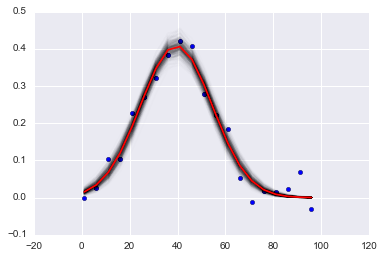

In [8]:
#import matplotlib.pyplot as plt
#import numpy as np 
def graph(formula, x_range, color='black', alpha=1):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y, color=color, alpha=alpha)
    
plt.scatter(x,f)

for i in range(1500,2000):
    point = trace1.point(i)
    graph('{0}*np.exp(-(x-{1})**2/(2.*{2}**2))'.format(point['amp1'], point['miu1'],point['sigma1']),
          x, color='black', alpha=.0098035)

amp_fit=0.408 
miu_fit=39.493
sigma_fit=15.03    
graph('amp_fit*np.exp(-(x-miu_fit)**2/(2.*sigma_fit**2))', x, color='red', alpha=1.0)
plt.show()